# Divvy Bikeshare Chicago - 2018
### Yernat Assylbekov


## 1. Introduction
<a href="https://www.divvybikes.com">Divvy</a> is a company that provides bikes for rent in Chicago. Users can rent an available bike from a nearby station and return to any station within the city. There are three types of service: single 30-minute ride for 3 USD, 24-hour pass for 15 USD with unlimited 3-hour rides, and annual membership (365 days) for 99 USD with unlimited 45-minute rides. Rides longer than aforesaid durations will be charged an extra 3 USD for additional 30 minutes.

In the current project, we perform exploratory analysis on the data that was collected from the Divvy System Data website which can be found <a href="https://www.divvybikes.com/system-data">here</a>. This Data Set contains the following information for each trip from 2018:<br/>
&#x25cf; Date, time and location of the start and end of the trip;<br/>
&#x25cf; Type, gender and birth year of the user.

### Posing questions:
Our aim is to answer the following questions:<br/>
Q1: What is the regular duration of the trip and how do the seasons affect it?<br/>
Q2: Who are main bike renters?<br/>
Q3: What part of the city has the most bike rentals?



## 2. Initial look at the data

The data comes in two parts. First part, trips data, has four csv files. One for each Quarter of 2018 which are titled with a `Divvy_Trips_2018_[Q*].csv` naming convention, where `* = 1, 2, 3, 4` stands for the numbering of each quarter. For each trip the following information is given:<br/>
&#x25cf; date and time of the start and end of the trip,<br/>
&#x25cf; station of the start and end of the trip,<br/>
&#x25cf; user type: 'Subscriber' if the user has annual membership and 'Customer' otherwise,<br/>
&#x25cf; gender and birth year for Subscribers.

The second part (`Divvy_Bicycle_Stations.csv`) contains information about all stations in the system.

We start with reading the first part of the data into four pandas DataFrames.

In [1]:
# import pandas
import pandas as pd

In [2]:
# initialize an empty list
input_trips = []

for i in range(1,5):
    # read each csv file into separate pandas DataFrame;
    # append each consecutive DataFrame into input_trips list
    input_trips.append(pd.read_csv('Divvy_Trips_2018_Q{}.csv'.format(i)))

Next, we combine four DataFrames into one and print out first few rows.

In [3]:
# concatenate all DataFrames in input_trips list
# with a new index
input_trips = pd.concat(input_trips)
input_trips = input_trips.reset_index(drop=True)

# display the first few rows of the input_trips DataFrame
input_trips.head()

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
0,17536702,2018-01-01 00:12:00,2018-01-01 00:17:23,3304,323.0,69,Damen Ave & Pierce Ave,159,Claremont Ave & Hirsch St,Subscriber,Male,1988.0
1,17536703,2018-01-01 00:41:35,2018-01-01 00:47:52,5367,377.0,253,Winthrop Ave & Lawrence Ave,325,Clark St & Winnemac Ave (Temp),Subscriber,Male,1984.0
2,17536704,2018-01-01 00:44:46,2018-01-01 01:33:10,4599,"2,904.0",98,LaSalle St & Washington St,509,Troy St & North Ave,Subscriber,Male,1989.0
3,17536705,2018-01-01 00:53:10,2018-01-01 01:05:37,2302,747.0,125,Rush St & Hubbard St,364,Larrabee St & Oak St,Subscriber,Male,1983.0
4,17536706,2018-01-01 00:53:37,2018-01-01 00:56:40,3696,183.0,129,Blue Island Ave & 18th St,205,Paulina St & 18th St,Subscriber,Male,1989.0


The format of the data is suitable to work with. Column names are informative. The column `tripduration` is in seconds. Let us get some more information about the data.

In [4]:
# display information about the input_trips DataFrame
input_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3603082 entries, 0 to 3603081
Data columns (total 12 columns):
trip_id              int64
start_time           object
end_time             object
bikeid               int64
tripduration         object
from_station_id      int64
from_station_name    object
to_station_id        int64
to_station_name      object
usertype             object
gender               object
birthyear            float64
dtypes: float64(1), int64(4), object(7)
memory usage: 329.9+ MB


This gives us several uselful informations. For instance, the total number of trips is 3603082.

## 3. Data wrangling

Let us first import <tt>DateTime.datetime</tt> package.

In [5]:
# import datetime and numpy
from datetime import datetime
import numpy as np

We start the wrangling process by making changes in the organization of the dataframe. We add a column for the age of a user. Next, we remove columns that will not be used: `trip_id, end_time, bikeid, from_station_id, to_station_id, birthyear`, and `gender`. We convert `tripduration` units from seconds to minutes. We also add a column for the day of the week.

In [6]:
# convert birthyear to age and save it as a new column
input_trips['age'] = 2018 - input_trips['birthyear']

# drop unnecessary columns
drop_cols = ['trip_id', 'end_time', 'bikeid', 'from_station_id', 'to_station_id', 'birthyear', 'gender']
input_trips.drop(drop_cols, axis='columns',inplace=True)

# convert dtype of the tripduration column from string to float
# then convert its units from seconds to minutes
input_trips['tripduration'] = pd.to_numeric(input_trips['tripduration'].str.replace(',','')) / 60

# convert dtype of the start_time column from string to datetime
input_trips['start_time'] = pd.to_datetime(input_trips['start_time'], format='%Y-%m-%d %H:%M:%S')

# create a new column that shows the weekday for each trip
input_trips['start_weekday'] = input_trips['start_time'].dt.weekday

Now `input_trips` looks as follows.

In [7]:
# display the first few rows of the input_trips DataFrame
input_trips.head()

,start_time,tripduration,from_station_name,to_station_name,usertype,age,start_weekday
0,2018-01-01 00:12:00,5.383333,Damen Ave & Pierce Ave,Claremont Ave & Hirsch St,Subscriber,30.0,0
1,2018-01-01 00:41:35,6.283333,Winthrop Ave & Lawrence Ave,Clark St & Winnemac Ave (Temp),Subscriber,34.0,0
2,2018-01-01 00:44:46,48.400000,LaSalle St & Washington St,Troy St & North Ave,Subscriber,29.0,0
3,2018-01-01 00:53:10,12.450000,Rush St & Hubbard St,Larrabee St & Oak St,Subscriber,35.0,0
4,2018-01-01 00:53:37,3.050000,Blue Island Ave & 18th St,Paulina St & 18th St,Subscriber,29.0,0


Next thing that we should do is to check missing values, which are labeled by 'NaN'. For this, we print out the numbers of non-null entries for each column.

In [8]:
# display the numbers of non-null entries
# in each column of the input_trips DataFrame
input_trips.count()

start_time           3603082
tripduration         3603082
from_station_name    3603082
to_station_name      3603082
usertype             3603082
age                  3047873
start_weekday        3603082
dtype: int64

We can see that the `birthyear` column has some missing values. But this makes sense, since birth year is available if the rider is a 'Subscriber' but not necesseraly if a 'Customer'. For that reason, we set entries of the `age` column for 'Customers' to be 'NaN'.

In [9]:
# set up the filter for 'Customers'
customer = input_trips.usertype == 'Customer'

# set entries of age column for 'Customers' to be 'NaN'
input_trips.loc[customer,'age'] = np.nan

After running the code below, we see that the previous code worked well.

In [10]:
# display the numbers of non-null entries in each column
# for 'Customers' of the input_trips DataFrame
input_trips[customer].count()

start_time           677156
tripduration         677156
from_station_name    677156
to_station_name      677156
usertype             677156
age                       0
start_weekday        677156
dtype: int64

Now we have missed values in the `age` column only for 'Subscriber' rows.

In [11]:
# set up the filter for 'Subscribers'
subscriber = input_trips.usertype == 'Subscriber'

# display the numbers of non-null entries in each column
# for 'Subscribers' of the input_trips DataFrame
input_trips[subscriber].count()

start_time           2925926
tripduration         2925926
from_station_name    2925926
to_station_name      2925926
usertype             2925926
age                  2922711
start_weekday        2925926
dtype: int64

We replace those missed values in the `age` column by the mean of all ages.

In [12]:
# calculate the average age among subscribers
average_age = np.ceil(input_trips.loc[subscriber,'age'].mean())

# replace missed values in the age column
# for subscribers with average_age
input_trips.loc[subscriber,'age'] = input_trips.loc[subscriber,'age'].fillna(average_age)

Printing out the number of non-null entries for each column we see that there are no missing values for 'Subscribers'.

In [13]:
# display the numbers of non-null entries in each column
# for 'Subscribers' of the input_trips DataFrame
input_trips[subscriber].count()

start_time           2925926
tripduration         2925926
from_station_name    2925926
to_station_name      2925926
usertype             2925926
age                  2925926
start_weekday        2925926
dtype: int64

Now that we have the tidied data, let us save it to a separate CSV file and work directly with that data file in the next section.

In [14]:
# write the cleaned data to 'Divvy_Trips_2018_clean.csv'
# with dropped indices
input_trips.to_csv('Divvy_Trips_2018_clean.csv', index=False)

Now, let us read `Divvy_Bicycle_Stations.csv` into a pandas DataFrame and print out first several rows to see how the data looks.

In [15]:
# read a csv file into pandas DataFrame;
stations = pd.read_csv('Divvy_Bicycle_Stations.csv')

# display the first few rows of the stations DataFrame
stations.head()

,ID,Station Name,Address,Total Docks,Docks in Service,Status,Latitude,Longitude,Location
0,11,Jeffery Blvd & 71st St,Jeffery Blvd & 71st St,11,11,In Service,41.766638,-87.576450,"(41.76663823695, -87.5764501141)"
1,106,State St & Pearson St,State St & Pearson St,27,27,In Service,41.897448,-87.628722,"(41.897448, -87.628722)"
2,661,Evanston Civic Center,Evanston Civic Center,15,15,In Service,42.057044,-87.686554,"(42.057044, -87.686554)"
3,622,California Ave & Cortez St,California Ave & Cortez St,15,15,In Service,41.900363,-87.696704,"(41.900363, -87.696704)"
4,665,South Chicago Ave & Elliot Ave,South Chicago Ave & Elliot Ave,7,7,In Service,41.747363,-87.580046,"(41.747363, -87.580046)"


We get rid off columns that are not needed for our work. We also rename the `Station Name` column to be `station_name`.

In [16]:
# drop unnecessary columns
drop_cols = ['ID', 'Address', 'Total Docks',
             'Docks in Service', 'Status', 'Location']
stations.drop(drop_cols, axis='columns', inplace=True)

# rename 'Station Name' column as 'station_name'
stations.rename(columns = {'Station Name':'station_name'}, inplace=True)

Now `stations` has the following form.

In [17]:
# display the first few rows of the stations DataFrame
stations.head()

,station_name,Latitude,Longitude
0,Jeffery Blvd & 71st St,41.766638,-87.576450
1,State St & Pearson St,41.897448,-87.628722
2,Evanston Civic Center,42.057044,-87.686554
3,California Ave & Cortez St,41.900363,-87.696704
4,South Chicago Ave & Elliot Ave,41.747363,-87.580046


The code below ensures that there are no missing values.

In [18]:
# display information about the stations DataFrame
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608 entries, 0 to 607
Data columns (total 3 columns):
station_name    608 non-null object
Latitude        608 non-null float64
Longitude       608 non-null float64
dtypes: float64(2), object(1)
memory usage: 14.3+ KB


We save the data to a CSV file.

In [19]:
# write the cleaned data to 'Divvy_Stations_clean.csv'
# with dropped indices
stations.to_csv('Divvy_Stations_clean.csv', index=False)

We are now ready to do an exploratory analysis.

## 4. Exploratory analysis

We first read cleaned data files into pandas DataFrames.

In [20]:
# read csv files with clean data into pandas DataFrames;
# recognize start_time column as TimesSeries object
trips = pd.read_csv('Divvy_Trips_2018_clean.csv', parse_dates=['start_time'])
stations = pd.read_csv('Divvy_Stations_clean.csv', index_col=0)

Since exploratory analysis heavily based on plots, let us import some necessary packages for plotting.

In [21]:
# import necessary packages
from matplotlib import pyplot as plt
import seaborn as sns

# set seaborn styling
sns.set()

Now, we are ready to analyze our data.

### 4.1. What is the regular duration of the trip?

We start by looking at the distribution of trip durations. To that end, we plot a duration versus number of trips histogram. Each bar stands for 5 minutes. Since there is an extra charge for riding longer in a single trip, it is natural to expect that most trip durations will be less than 30 minutes.

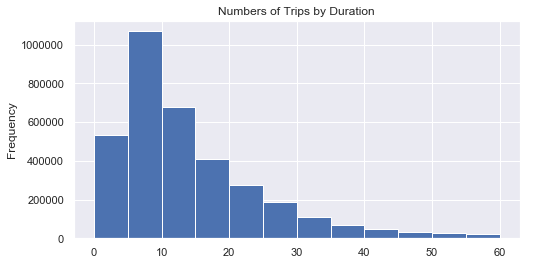

In [22]:
# select the tripduration column of the trips DataFrame
# for which tripduration <= 60
durations = trips.loc[trips.tripduration <= 60,'tripduration']

# setup bins from 0 to 60 minutes with 5 minutes increment
bins = np.arange(0,61,step=5)

# draw and show the histogram for the durations Series
durations.plot.hist(bins=bins, figsize=[8,4], title='Numbers of Trips by Duration')
plt.show()

The plot shows that about 2400000 trips (out of 3594137) last less than 15 minutes. Also, about 850000 trips have a duration of more than 15 minutes, but less than 30 minutes. Hence, the most of trips (about 90%) are less than 30 minutes as expected.

Let us now explore how seasons affect to trip durations.

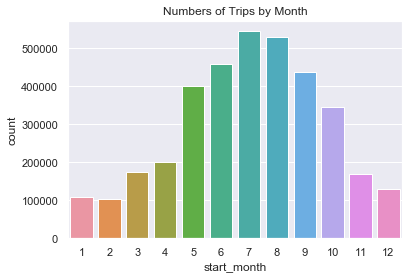

In [23]:
# create a new column that shows the month for each trip
trips['start_month'] = trips.start_time.dt.month

# draw and show the countplot for the start_month column
sns.countplot(x='start_month', data=trips)
plt.title('Numbers of Trips by Month')
plt.show()

Clearly, the peak of bike rents is during late Spring, Summer and early Autumn thanks to favorable weather conditions. But, bike rental reaches its least amount in winter time due to severe winters in Chicago. During this period, it seems that bulk of people prefer to use alternative ways of transportation. It is probably the best season to schedule annual bike maintenance work.

In fact, as we demonstrate below, even trip durations will be dropped during winter.

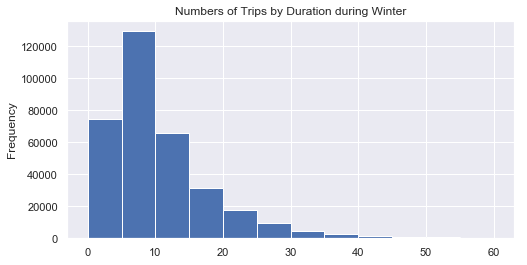

In [24]:
# set up the filter for 'Winter' in trips DataFrame
winter_filter = trips.start_month.isin([1,2,12])

# select the tripduration column of the trips DataFrame
# via winter_filter for which tripduration <= 60 
durations_winter = trips.loc[winter_filter & (trips.tripduration <= 60),'tripduration']

# draw and show the histogram for the durations_winter Series
durations_winter.plot.hist(bins=bins, figsize=[8,4], title='Numbers of Trips by Duration during Winter')

In [25]:
# count the total number of winter trips
winter_filter.sum()

341628

From the plot, it is not difficult to see that about 310000 winter trips (out of 341628) last less than 20 minutes. This is about 90%.

### 4.2. Who are main bike renters?

Let us first look how trips are divided by user types. The code below shows how many 'Subscriber' and 'Customer' trips are made.

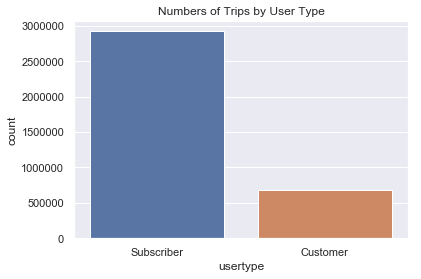

In [26]:
# draw and show the countplot for the usertype column
sns.countplot(x='usertype', data=trips)
plt.title('Numbers of Trips by User Type')
plt.show()

We see that about 80% of trips are made by 'Subscribers' while 20% by 'Customers'. Based on this, we conjecture that 'Subscribers' are primarily people commuting to and from work, and 'Customers' are mainly tourists (in a broad sense).

Let us introduce 'Subscriber' and 'Customer' filters that will be used several times.

We concentrate on many factors in the data that affect to the numbers of trips. We look at the numbers of 'Subscriber' and 'Customer' trips by weekdays. In the plot shown below, weekdays are numbered from 0 to 6, where 0 is for Monday and 6 is for Sunday.

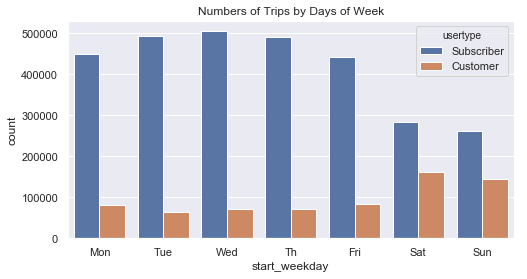

In [27]:
# draw and show the countplot for the start_weekday column
# hue by usertype column
plt.figure(figsize=(8,4))
sns.countplot(x='start_weekday', hue='usertype', data=trips)
plt.title('Numbers of Trips by Days of Week')
plt.xticks([0,1,2,3,4,5,6],['Mon', 'Tue', 'Wed', 'Th', 'Fri', 'Sat', 'Sun'])
plt.show()

The numbers of 'Subscriber' trips during workdays are high, and reduces sharply during weekends. The numbers of 'Customer' trips are behaving in the opposite way. These observations fit with our conjecture, since commuting people are more active during workdays while tourist flow increases during weekends.

For more confirmation of our conjecture, we look at the numbers of trips by hours during workdays and weekends.

In [28]:
# set up filters for 'Subscribers' and 'Customers'
subscriber = trips['usertype'] == 'Subscriber'
customer = trips['usertype'] == 'Customer'

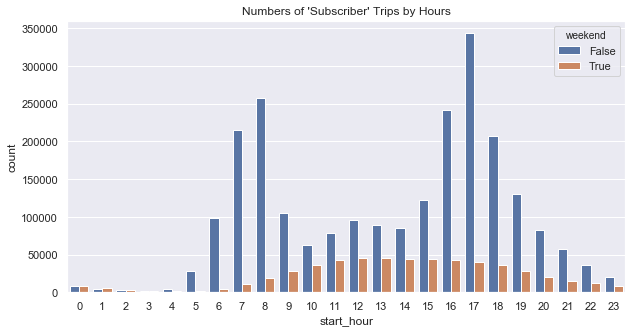

In [29]:
# create a new column that shows whether each trip was the weekend
trips['weekend'] = trips.start_weekday.isin([5,6])

# create a new column that shows the start hour for each trip
trips['start_hour'] = trips.start_time.dt.hour

# draw and show the countplot for the start_hour column
# hue by weekend column
# filter to 'Subscribers'
plt.figure(figsize=(10,5))
sns.countplot(x='start_hour', hue='weekend', data=trips[subscriber]) 
plt.title('Numbers of \'Subscriber\' Trips by Hours')
plt.show()

During workdays, the numbers of 'Subscriber' trips are very high from 7 a.m. to 9 a.m. and from 4 p.m. to 7 p.m. These are the usual time periods when people commute to and from work. Usually, people work in offices from 9 a.m. to 4:30 p.m. and the plot shows that the numbers of trips are reduced during this time interval. According to the plot, we can see that numbers of 'Subscriber' trips during weekends are much less with most of the rents being made between 10 a.m. and 6 p.m. This makes sense, since working people usually have a later start days during weekends.

With the following code, we observe that the numbers of 'Customer' trips during weekdays and weekends do not differ much.

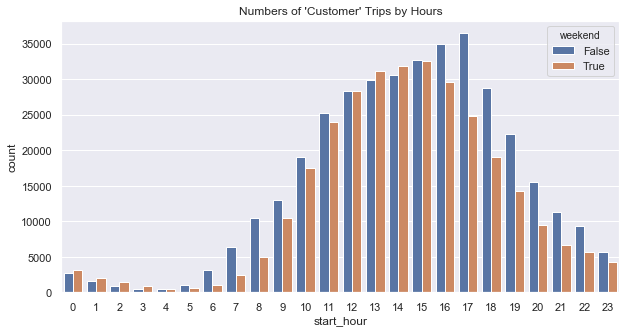

In [30]:
# draw and show the countplot for the start_hour column
# hue by weekend column
# filter to 'Customers'
plt.figure(figsize=(10,5))
sns.countplot(x='start_hour', hue='weekend', data=trips[customer]) 
plt.title('Numbers of \'Customer\' Trips by Hours')
plt.show()

Now we explore how 'Subscriber' trips are distributed by ages. This will help us determine the ages of most of 'Subscribers'. We filter down the age interval to adult working ages (from 18-60 years).

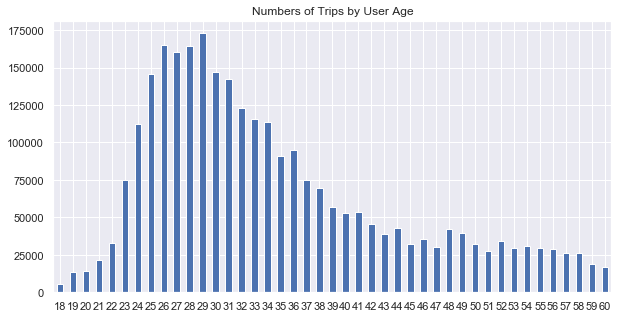

In [31]:
# convert dtype of the age column for 'Subscribers' to integer
subs_age = trips.loc[subscriber,'age'].astype(int)

# count the number of 'Subscriber' trips by age
# for ages between 18 and 60
age_count = subs_age[(18 <= subs_age) & (subs_age <= 60)].value_counts().sort_index()

# draw and show the barplot for the age_count Series
age_count.plot.bar(rot=0, figsize=[10,5], color='b', title='Numbers of Trips by User Age')

It seems that the bulk of 'Subscribers' are 23-41 years old. This gives more affirmation of our hypothesis, since most office employees are young or middle-aged.

### 4.3. What part of Chicago has the most and least bike rentals?

To see the most popular and least popular stations within each part of the city, it is helpful to view the rentals data on a map. To that end, we create a new Series which shows the number of rentals made from each station during weekdays and weekends.

In [32]:
# create an empty DataFrame
stations_trips_n = pd.DataFrame()

# add two columns to count the number of rentals made
# from each station
# one column for weekends and another for weekdays
stations_trips_n['weekends'] = trips.loc[trips['weekend'],'from_station_name'].value_counts()
stations_trips_n['weekdays'] = trips.loc[~trips['weekend'],'from_station_name'].value_counts()

# change the name of indices to station_name
stations_trips_n.index.names = ['station_name']
stations_trips_n.head()

,weekends,weekdays
station_name,,
Streeter Dr & Grand Ave,28877,38067
Lake Shore Dr & Monroe St,16648,19526
Lake Shore Dr & North Blvd,13360,17843
Theater on the Lake,12854,17825
Michigan Ave & Oak St,11024,18350


Next, we merge `stations_trips_n` and `stations` DataFrames on their indices and display first few rows.

In [33]:
# merger stations_trips_n and stations DataFrames on indices
# print out the info of the resultant DataFrame
stations_trips_n_loc = pd.merge(stations_trips_n,stations,how='left',on='station_name')
stations_trips_n_loc.head()

,weekends,weekdays,Latitude,Longitude
station_name,,,,
Streeter Dr & Grand Ave,28877,38067,41.892278,-87.612043
Lake Shore Dr & Monroe St,16648,19526,41.880958,-87.616743
Lake Shore Dr & North Blvd,13360,17843,41.911722,-87.626804
Theater on the Lake,12854,17825,41.926277,-87.630834
Michigan Ave & Oak St,11024,18350,41.900960,-87.623777


Let us check if there are any missing values.

In [34]:
stations_trips_n_loc.count()

weekends     616
weekdays     616
Latitude     596
Longitude    596
dtype: int64

It seems that the DataFrame `stations_trips_n_loc` is lack of coordinates for some stations. Let us drop those stations and ensure that there are no missing values.

In [35]:
# Drop rows containing 'NaN'
stations_trips_n_loc.dropna(inplace=True)
stations_trips_n_loc.count()

weekends     596
weekdays     596
Latitude     596
Longitude    596
dtype: int64

Now that we have clean data, we can proceed to plotting the data on a map. This will be done by marking stations on the map as circles. Colors of circles will represent busyness of stations. More precisely, darker circles represent busy stations and lighter circles represent stations with low rentals.

To work with geospatial data, we use Bokeh package. The approach that we use for this part is learned from Colin Patrick Reid's <a href=https://towardsdatascience.com/exploring-and-visualizing-chicago-transit-data-using-pandas-and-bokeh-part-ii-intro-to-bokeh-5dca6c5ced10>article</a>. We build separate maps for weekdays and weekends:

In [36]:
# import necessary modules from Bokeh
from bokeh.plotting import figure, show, output_notebook
from bokeh.tile_providers import CARTODBPOSITRON

# create first figure for weekdays and add a tile
plot1 = figure(title='Weekdays', tools=['pan','wheel_zoom','save'],
           x_axis_type='mercator', y_axis_type='mercator')
plot1.add_tile(CARTODBPOSITRON)

# create second figure for weekends and add a tile
plot2 = figure(title='Weekends', tools=['pan','wheel_zoom','save'],
           x_axis_type='mercator', y_axis_type='mercator')
plot2.add_tile(CARTODBPOSITRON)

TileRenderer(id='1076', ...)

In the code above, the <tt>x_axis_type</tt> and <tt>y_axis_type</tt> parameters specify that for plotting the map we use the <b>Mercator projection</b> which converts the spherical coordinates of the earth (latitude and longitude) onto the Cartesian coordinates X and Y on a plane. Using the Mercator projection formulas, taken from <a href=https://en.wikipedia.org/wiki/Mercator_projection>Wikipedia</a>, we create two functions which convert latitude and longitude coordinates to X and Y coordinates, respectively.

In [37]:
import math

def merc_pr_x(coord):
    """converts latitude and longitude coordinates to X coordinate"""
    lat, lon = coord['Latitude'], coord['Longitude']
    pi = 3.14159265359
    r = 6378137.0
    x = r * math.radians(lon)
    return x

def merc_pr_y(coord):
    """converts latitude and longitude coordinates to Y coordinate"""
    lat, lon = coord['Latitude'], coord['Longitude']
    pi = 3.14159265359
    r = 6378137.0
    y = r * math.log(math.tan(pi/4.0 + math.radians(lat)/2))
    return y

We apply these functions to `stations_trips_n_loc` and save them as new columns in the DataFrame.

In [38]:
# add two new columns for X and Y coordinates
# of the Mercator projection for each station
stations_trips_n_loc['merc_x'] = stations_trips_n_loc.apply(lambda row: merc_pr_x(row),axis=1)
stations_trips_n_loc['merc_y'] = stations_trips_n_loc.apply(lambda row: merc_pr_y(row),axis=1)

Now, we create a ColumnDataSource object from `stations_trips_n_loc` that will contain all the data for the plots. After that, we add circles on the earlier created maps.

In [39]:
# import some more necessary modules from Bokeh
from bokeh.models import ColumnDataSource, ColorBar, LinearColorMapper
from bokeh.palettes import Inferno256

# set up the source
source = ColumnDataSource(stations_trips_n_loc)

# reverse the Inferno256 palette
Inferno256.reverse()

# define color mappers for weekdays and weekends
mapper1 = LinearColorMapper(palette=Inferno256, low=0, high=60000)
mapper2 = LinearColorMapper(palette=Inferno256, low=0, high=30000)

# set up the color bars using the above mappers
color_bar1 = ColorBar(color_mapper=mapper1, location=(0, 0))
color_bar2 = ColorBar(color_mapper=mapper2, location=(0, 0))

# add circle glyphs to the plots
plot1.circle(x='merc_x', y='merc_y', source = source, size = 5, line_color=None,
             fill_color={'field': 'weekdays', 'transform': mapper1})
plot2.circle(x='merc_x', y='merc_y', source = source, size = 5, line_color=None,
             fill_color={'field': 'weekends', 'transform': mapper2})

# add color bars to the plots from the right
plot1.add_layout(color_bar1, 'right')
plot2.add_layout(color_bar2, 'right')

We use HoverTool, Bokeh's interactive tool, to display the name of each station and the number of committed rentals when a user points on a circle.

In [40]:
# import HoverTool
from bokeh.models import HoverTool

# set up HoverTools for weekdays and weekends
# to display station names and the number of trips
hover1 = HoverTool(tooltips=[('Station','@station_name'),('Weekdays','@weekdays')])
hover2 = HoverTool(tooltips=[('Station','@station_name'),('Weekends','@weekends')])

# add the HoverTools to the plots
plot1.add_tools(hover1)
plot2.add_tools(hover2)

# Link axes of plot1 and plot2
plot1.x_range = plot2.x_range
plot1.y_range = plot2.y_range

Let us now display the plot for weekdays.

In [41]:
output_notebook()
show(plot1)

Loading BokehJS ...

Zooming in the plot, we can see that during weekdays the downtown area has the most bike rentals. When we point on a circle, representing a station, we can see the station name and the total number of rentals made from the station during weekdays.

This information might be useful for the company to supply the demanded stations with extra bikes.

During weekends, as the next plot shows, most of bike rentals are made in lakefront areas such as Navy Pier and Chicago Yacht Club.

In [42]:
show(plot2)

## 5. Conclusions

In this project, we have gone through the main stages of the data analysis process, including the questions generation, data wrangling, exploratory analysis, and data visualization. Of course there are many data analysis questions, not considered in the project, that would be interesting to study. For instance, we did not considered how other factors, such as weather conditions, are affecting the data. It would also be interesting to explore which routes are most popular and which are not.